# Overview

This notebook will continue analysing New York Yellow taxi cab demand. Based on the demand group insight obtained in the analysis notebook, we will predict the average hourly rides in two out of the three groups (medium and high). The goal is to accurately predict hourly taxi demands in these areas to provide adequate taxis to meet with the demand. Model development will be based on historical taxi rides in New York between January 2019 and March 2024 in these demand groups and evaluate the model's performance on taxi rides in April 2024. 

# Approach

## Data Preprocessing
But firstly, we will preprocess the new dataset (April 2024) to resemble the historical data. After that, we will perform feature engineering (transformations, categorical encoding and extraction of new features) to improve model performance. New features to be created would be the time features such as year, month, season, and hour. We will add forecasted hourly weather conditions downloaded from [Open-Meteo](https://open-meteo.com/) to improve the model's performance using their weather API. We assume that the predicted weather conditions of the next hour may affect demand. For example, if it rains the next hour, there may be an increase in taxi demand. Similarly, the average taxi demand in the preceding hours may also help improve model performance. As a result, we will create lagged and rolling features of taxi demand in these demand groups.

# Modelling

This modelling will be a time series task. We will split the historical data into train and validation sets. The validation data will contain the latest taxi demand data to resemble the test set and estimate how our model will perform on the test dataset.

A simple baseline model will predict each demand group's average hourly rides per month. After that, further approaches would be to improve performance.

## Loading Libraries and Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import lightgbm as lgb
import catboost as cat
from feature_engine.datetime import DatetimeFeatures
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from feature_engine.encoding import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
import plotnine as pn
from IPython.display import display
import holidays

In [2]:
data = pd.read_csv('nyc_hourly_rides.csv', parse_dates=['ride_datetime'])
new_data = pd.read_parquet('data/yellow_tripdata_2024-04.parquet')
station_demand = pd.read_csv('station_demand_group.csv')
weather = pd.read_csv('weather_2019-01-01_to_2024-04-30.csv', parse_dates=['date'])

## Data Exploration

In [3]:
data.head()

,ride_datetime,avg_hourly_rides,demand_group
0,2019-01-01 00:00:00,219.2000,high
1,2019-01-01 00:00:00,6.3711,low
2,2019-01-01 00:00:00,141.5313,medium
3,2019-01-01 01:00:00,244.3333,high
4,2019-01-01 01:00:00,12.6429,low


In [4]:
new_data.head(2)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,1,2024-04-01 00:02:40,2024-04-01 00:30:42,0.0,5.2,1.0,N,161,7,1,29.6,3.5,0.5,8.65,0.0,1.0,43.25,2.5,0.0
1,2,2024-04-01 00:41:12,2024-04-01 00:55:29,1.0,5.6,1.0,N,264,264,1,25.4,1.0,0.5,10.00,0.0,1.0,37.90,0.0,0.0


In [5]:
station_demand.head(3)

,pickup_station,group
0,1,Low
1,2,Low
2,3,Low


In [6]:
weather.head(4)

,date,temperature_2m,relative_humidity_2m (%),apparent_temperature,precipitation,lat,long
0,2019-01-01 00:00:00+00:00,5.6575,94,1.943899,1.1,40.71427,-74.00597
1,2019-01-01 01:00:00+00:00,5.9075,96,2.698992,2.9,40.71427,-74.00597
2,2019-01-01 02:00:00+00:00,6.4575,95,3.667387,2.2,40.71427,-74.00597
3,2019-01-01 03:00:00+00:00,6.7575,95,4.112215,10.1,40.71427,-74.00597


In [7]:
data.shape

(137994, 3)

In [8]:
# get holidays in the US from beginning to current
us_holidays = holidays.UnitedStates(years=list(range(min(data.ride_datetime.dt.year), 
                                                     max(data.ride_datetime.dt.year)+1)))
us_holidays = pd.DataFrame(us_holidays.items(), columns=['date', 'name'])
us_holidays = us_holidays.sort_values('date').reset_index(drop=True)

In [9]:
station_demand.group = station_demand.group.str.lower()

### Visualisation

In [10]:
# summary statistics
data.pivot(columns='demand_group', index='ride_datetime', values='avg_hourly_rides').describe().T

,count,mean,std,min,25%,50%,75%,max
demand_group,,,,,,,,
high,45993.0,123.773394,104.464494,1.0,29.3333,110.40000,183.93330,534.2667
low,46000.0,2.926801,1.363811,1.0,1.8409,2.73885,3.71015,12.6429
medium,46001.0,53.522088,43.108503,1.0,15.0968,49.68750,75.00000,276.5000


- All demand group had 1 ride in a certain hour
- Low demand group had a maximum of 12 rides in an hour. We will drop rows for low demand group since they won't be of much importance since the aim is to accurately predict demand for appropriate logistics.

#### Distribution of hourly rides by group

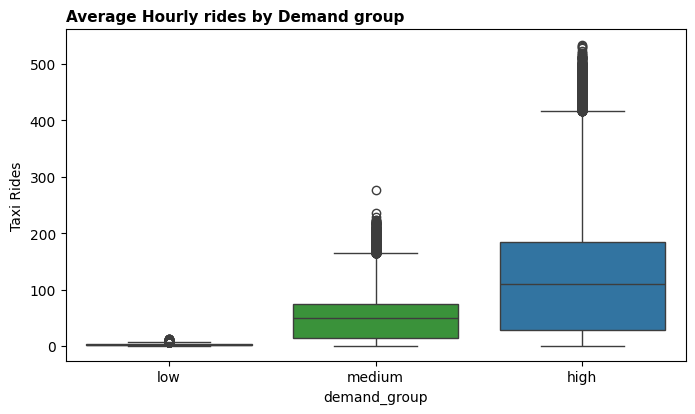

In [11]:
plt.figure(figsize=(8,4.3))
sns.boxplot(data, x='demand_group', y='avg_hourly_rides', hue='demand_group', 
            order=['low', 'medium', 'high'])
plt.title('Average Hourly rides by Demand group', loc='left', fontsize=11, fontweight='bold')
plt.ylabel('Taxi Rides')
plt.show()

#### Daily demand by group

In [12]:
weekday_rides = (
    data.assign(hour=data.ride_datetime.dt.hour,
                weekday = data.ride_datetime.dt.weekday)
        .groupby(['weekday', 'hour', 'demand_group']).avg_hourly_rides.mean()
        .unstack(2)
)

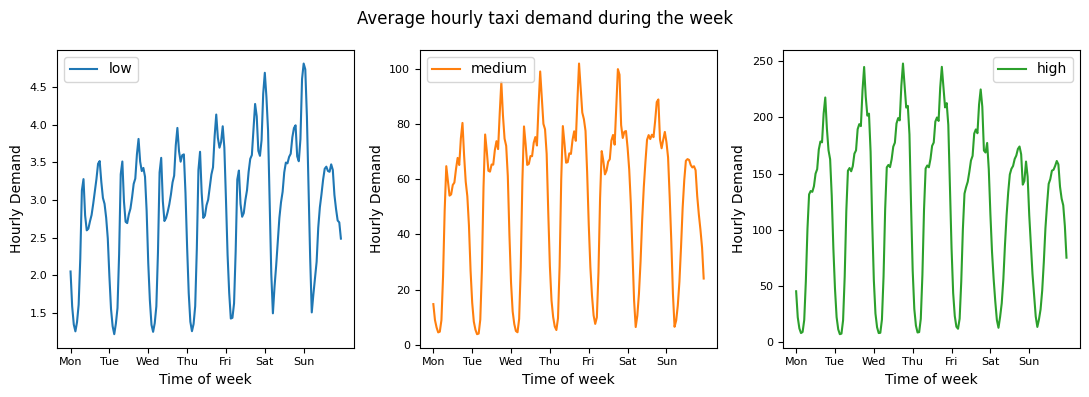

In [13]:
# fig, ax= plt.subplots(figsize=(10,4), dpi=150)
ax = weekday_rides[['low', 'medium', 'high']].plot(subplots=True, layout=(1,3), figsize=(11,4),
                       title='Average hourly taxi demand during the week',
                       ylabel='Hourly Demand', xlabel='Time of week', fontsize=8)
plt.xticks([i * 24 for i in range(7)], ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
plt.tight_layout()
plt.show()

- For all demand areas, demand is lowest on Sunday
- For low demand areas, the demand for rides increases during the week
- For medium and high, it increases from Monday and relatively remains the same throughout the week except on weekends

#### Daily demand in demand areas during holidays and non-holidays

In [14]:
weekday_rides = (
    data.assign(hour=data.ride_datetime.dt.hour,
                is_holiday=data.ride_datetime.dt.date.isin(us_holidays.date),
                weekday = data.ride_datetime.dt.weekday)
        .groupby(['weekday', 'hour', 'demand_group', 'is_holiday']).avg_hourly_rides.mean()
        .reset_index(level=[2,3])
)

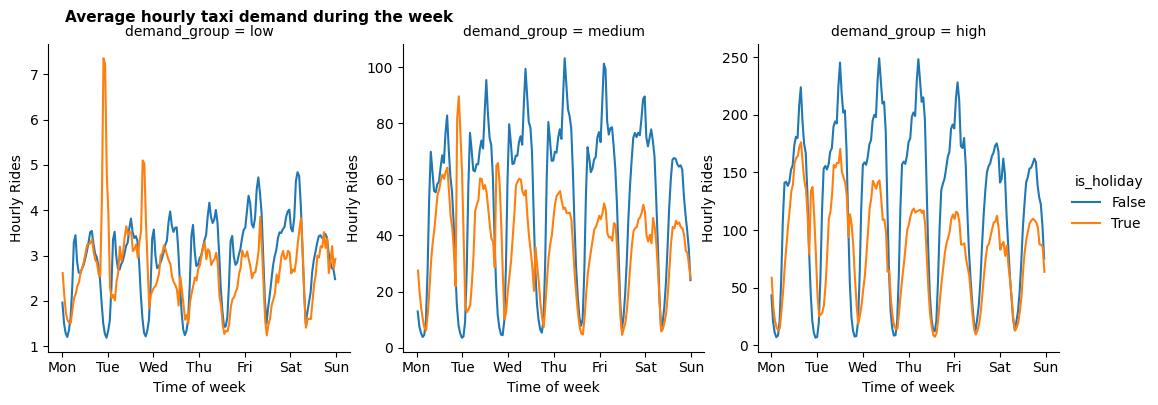

In [15]:
d = sns.relplot(weekday_rides, x=range(0,len(weekday_rides)), y='avg_hourly_rides', 
                hue='is_holiday', col='demand_group', kind='line', 
                aspect=.9, height=4, facet_kws={'sharey':False}, 
                col_order=['low', 'medium', 'high'])

d.set(xticks=[i * 24*7 for i in range(7)], ylabel='Hourly Rides', 
      xlabel='Time of week')
d.set_xticklabels(["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
plt.suptitle('Average hourly taxi demand during the week', y=1.0, fontsize=11, x=0.23, fontweight='bold')
d.despine();

- Demand is also affected by holiday and non-holidays. Lower demand during holidays

In [16]:
demand_monthly_rides = (
    data
    .pivot(columns='demand_group', index='ride_datetime', values='avg_hourly_rides')
    .rolling('28D').mean()
    .reset_index().melt(id_vars='ride_datetime', value_name='rides')
)

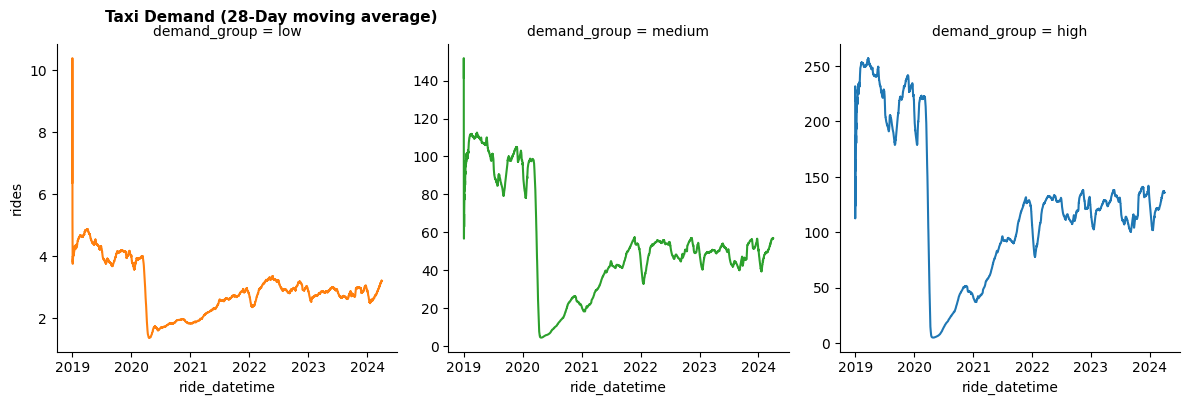

In [17]:
sns.relplot(demand_monthly_rides, x='ride_datetime', y='rides', hue='demand_group', 
            col='demand_group', kind='line', aspect=1, height=4, legend=False,
            facet_kws={'sharey':False}, col_order=['low', 'medium', 'high'])
plt.suptitle('Taxi Demand (28-Day moving average)', y=1.0, fontsize=11, x=0.23, fontweight='bold');

In [18]:
data.pivot(columns='demand_group', index='ride_datetime', 
           values='avg_hourly_rides').resample('ME').mean()[14:35]

demand_group,high,low,medium
ride_datetime,,,
2020-03-31,94.999462,2.608939,44.704695
2020-04-30,5.030768,1.402341,4.618032
2020-05-31,6.809483,1.702374,5.828882
2020-06-30,13.648428,1.687634,8.414476
2020-07-31,20.579858,1.741007,11.132022
2020-08-31,26.703521,1.828960,14.027971
2020-09-30,39.419459,1.878191,20.086987
2020-10-31,49.962599,1.957599,25.324542
2020-11-30,46.365617,1.899701,23.548067


#### Correlation

In [19]:
# remove UTC timezone to none
weather.date = weather.date.dt.tz_convert(None)

In [20]:
weather.select_dtypes('number').describe()

,temperature_2m,relative_humidity_2m (%),apparent_temperature,precipitation,lat,long
count,46728.000000,46728.000000,46728.000000,46728.000000,4.672800e+04,46728.00000
mean,12.620202,66.438388,10.750268,0.135951,4.071427e+01,-74.00597
std,9.670907,20.125199,12.236330,1.540261,1.421101e-14,0.00000
min,-16.892500,8.000000,-24.796299,0.000000,4.071427e+01,-74.00597
25%,4.857500,50.000000,0.704694,0.000000,4.071427e+01,-74.00597
50%,12.207500,68.000000,9.658443,0.000000,4.071427e+01,-74.00597
75%,20.807500,84.000000,21.259793,0.000000,4.071427e+01,-74.00597
max,37.257500,100.000000,42.437160,100.400000,4.071427e+01,-74.00597


In [21]:
corr = (
    data.pivot(columns='demand_group', index='ride_datetime', values='avg_hourly_rides')
    .reset_index()
    .merge(weather, left_on='ride_datetime', right_on='date')
    .eval('mean_temp = (apparent_temperature + temperature_2m)/2')
    .eval('temp_diff = abs(apparent_temperature - temperature_2m)')
    .drop(columns=['lat', 'long'])
    .corr(numeric_only=True)
)

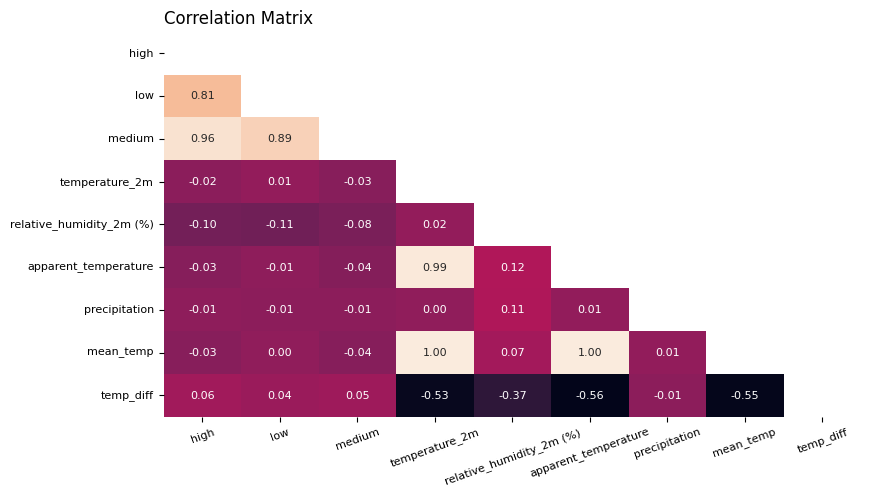

In [22]:
fig, ax = plt.subplots(figsize=(9,5), dpi=100)
sns.heatmap(corr, mask=np.triu(corr), fmt='.2f', annot=True, 
            annot_kws={'fontsize':8}, cbar=False)
plt.title('Correlation Matrix', loc='left')
plt.xticks(fontsize=8, rotation=20)
plt.yticks(fontsize=8);

## Feature Engineering & Preprocessing

- We will create time-related features
- Merge weather data
- Encode categorical variables and transform numerical variables
- Average the temperature and apparent temperature and absolute difference since they show perfect correlation (from correlation matrix)
- Filter data and select data from May 2021 till present. We will also select datasets for medium and high-demand areas since they are major area of focus.

The first three steps will be done in a pipeline of functions

In [23]:
criteria = (
    (data.ride_datetime >= pd.to_datetime('2021-05-01')) & 
    (data.ride_datetime <= pd.to_datetime('2024-04-01'))
)

filtered_data = data.loc[criteria].query("demand_group != 'low'").reset_index(drop=True)

In [24]:
# filter out low from station demand
station_demand = station_demand.query("group != 'low'").reset_index(drop=True)

#### __Visualise weather data__

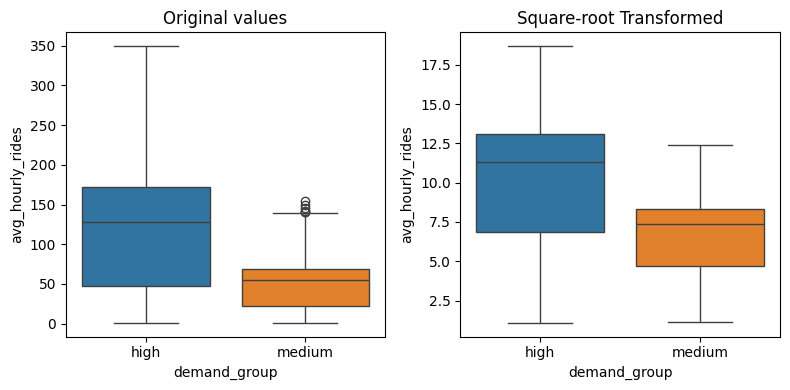

In [25]:
fig, ax = plt.subplots(1,2, figsize=(8,4))
sns.boxplot(filtered_data, y='avg_hourly_rides', x='demand_group', ax=ax[0], hue='demand_group')
ax[0].set_title('Original values')

sns.boxplot(filtered_data.assign(
    avg_hourly_rides = filtered_data.avg_hourly_rides.map(np.sqrt)
), x='demand_group', y='avg_hourly_rides', ax=ax[1],hue='demand_group')
ax[1].set_title('Square-root Transformed')
fig.tight_layout();

- No group is affected by outliers. Hence, we will use them in their original values

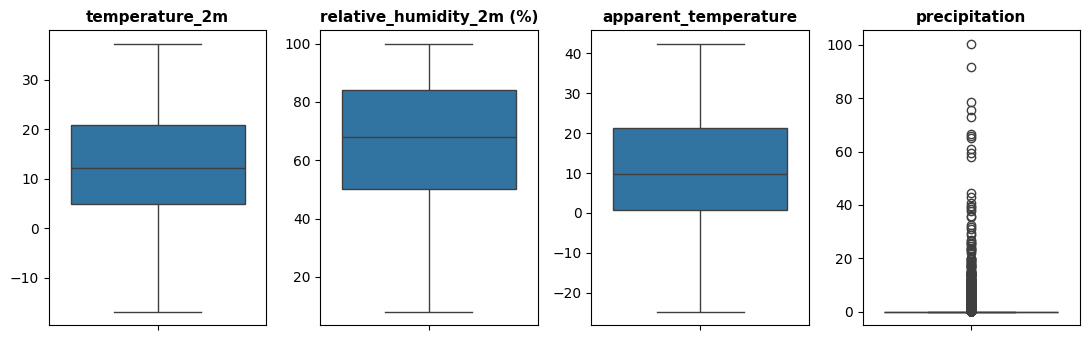

In [26]:
plt.figure(figsize=(11,3.5))
for i, col in enumerate(weather.columns[1:5]):
    plt.subplot(1,4,i+1)
    sns.boxplot(weather, y=col)
    plt.title(col, fontsize=11, fontweight='bold')
    plt.ylabel('')
plt.tight_layout()
plt.show()

- We will classify precipitation (in millimeters) into groups.
    - 'no' -> 0 mm
    - 'light' -> between 0 and 2.6 (exclusive)
    - 'moderate' -> between 2.6 and 7.6
    - 'heavy' -> above 7.6

#### __Helper data preprocessing functions__

In [27]:
def season(x):
    if x in range(3,6): return 'spring'
    elif x in range(6,9): return 'summer'
    elif x in range(9,12): return 'fall'
    else: return 'winter'

In [28]:
def rain_class(x):
    if x == 0: return 'no'
    elif 0 < x < 2.6: return 'light'
    elif 2.6 <= x <= 7.6: return 'moderate'
    elif x > 7.6: return 'heavy'
    else: return 'invalid'
    return x

def is_snow(x):
    if x < 1: 
        return 1
    else:
        return 0

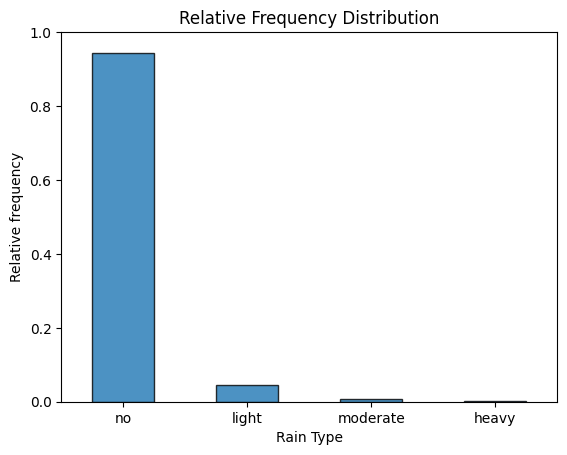

In [29]:
weather.precipitation.map(rain_class).value_counts(normalize=True).plot.bar(
    alpha=0.8, rot=0, edgecolor='black', title='Relative Frequency Distribution', 
    ylabel='Relative frequency', xlabel='Rain Type', ylim=(0,1)
);

- New York weather is mostly characterised by no rainfall

In [30]:
def feature_engineer(df):
    """
    Function 
    a. merges weather to demand data
    b. creates some time features (holiday and season)
    c. bins precipitation into four classes and drops precipitation
    d. dummy encode demand group variable
    
    Returns
    -------
    df: pandas dataframe with engineered features
    """
    # merge weather
    df = df.merge(weather, left_on='ride_datetime', right_on='date'
                 ).drop(['date', 'lat', 'long'], axis=1)

    df = df.assign(
        mean_temp = (df.apparent_temperature + df.temperature_2m)/2,
        abs_temp_diff = np.abs(df.temperature_2m - df.apparent_temperature)
        )
    # drop temperature features
    df = df.drop(['temperature_2m', 'apparent_temperature'], axis=1)

    # create holiday and season
    df = df.assign(holiday=1*df.ride_datetime.dt.date.isin(us_holidays.date),
                   season = df.ride_datetime.dt.month.map(season)
                  )

    # create rain class
    df['rain_class'] = df.precipitation.map(rain_class)
    df['is_snow'] = df.mean_temp.map(is_snow)
    # remove precipitation after creating rain class
    df = df.drop('precipitation', axis=1)
    # convert to dummy variable
    df.demand_group = df.demand_group.map({'high':1, 'medium':0})
    return df

In [31]:
def prepare_test(df):
    """
    Function
    a. selects rides paid by cash or card and rows where total amount is positive
    b. converts pickup time to nearest hour
    c. groups the pickup station and finding rides at particular hour of day
    d. renames grouped data and selects only data for April 2024
    e. groups pickup stations based on demand group, groups them and gets their mean hourly demand

    Returns
    -------
    prepared test data
    -------
    """
    # filter rows where taxi customer paid by cash or card and total amount is positive
    df = df.query('(payment_type < 2) & (total_amount > 0)').reset_index(drop=True)
    
    # convert to hour, group by pickup station and time
    df['tpep_pickup_datetime'] = pd.DatetimeIndex(df['tpep_pickup_datetime']).floor('h')
    test = df.groupby(
        ['tpep_pickup_datetime', 'PULocationID']).agg({'payment_type' : 'count'}).reset_index()
    test = test.rename(
        {'tpep_pickup_datetime' : 'ride_datetime', 
         'payment_type' : 'hourly_rides',
         'PULocationID' : 'pickup_station'
        }, axis=1)

    # filter out rows for april
    april = (
        (test.ride_datetime >= pd.to_datetime('2024-04-01 00:00:00')) & 
        (test.ride_datetime < pd.to_datetime('2024-05-01 00:00:00'))
    )
    test = test.loc[april]

    # assign to groups
    high = station_demand.query("group == 'high'").pickup_station.tolist()
    test['demand_group'] = test.pickup_station.apply(lambda x: 'high' if x in high else 'medium')

    test = test.groupby(['ride_datetime', 'demand_group']).hourly_rides.mean()
    test = test.reset_index().rename({'hourly_rides' : 'avg_hourly_rides'}, axis=1)
    return test

In [32]:
def preprocessor(df, data_type='train'):
    """
    Returns preprocessors performed on train data which will be used for transformation
    """
    if data_type == 'train':
        df = feature_engineer(df)
        # get time features
        time_features = ['weekend', 'hour', 'month', 'year', 'week', 'quarter', 
                         'day_of_year', 'day_of_week']
        date_features_fit = DatetimeFeatures(variables='ride_datetime', 
                                             features_to_extract=time_features,
                                             drop_original=False
                                            ).fit(df)

        # one hot encode
        one_hot = OneHotEncoder(variables=['rain_class', 'season']).fit(df)
        return date_features_fit, one_hot
    return None, None

In [33]:
def preprocess_data(df, onehot_encoder=None, date_preprocessor=None):
    """
    Preprocesses both train and test data
    Returns
    -------
    Preprocessed data
    """
    df = feature_engineer(df)
    
    if onehot_encoder is None and date_preprocessor is None:
        raise TypeError ('onehot_encoder and date_preprocessor must not be None')

    time_features = date_preprocessor.transform(df)
    df = onehot_encoder.transform(df)
    
    same_cols = time_features.columns.intersection(df.columns)
    df = df.merge(time_features, on=same_cols.tolist())

    # remove rain_class and season
    df = df.drop(['rain_class', 'season'], axis=1)
    # remove ride_datetime_ from created time features like ride_datetime_month etc
    df.columns = df.columns.str.replace('ride_datetime_|[\s(%)]', '', regex=True)
    df = df.set_index('ride_datetime')
    return df

#### Data Preprocessing

In [34]:
date_encoder, onehot_encoder = preprocessor(filtered_data, 'train')

In [35]:
filtered_data = preprocess_data(filtered_data, onehot_encoder, date_encoder)

In [36]:
test = prepare_test(new_data)
test = preprocess_data(test, onehot_encoder, date_encoder)

In [37]:
filtered_data.shape, test.shape

((51162, 23), (1440, 23))

#### __Checking for missing values__

In [38]:
# checking for missing values
filtered_data.isna().sum().any(), test.isna().sum().any()

(False, False)

In [39]:
filtered_data.head(2)

,avg_hourly_rides,demand_group,relative_humidity_2m,mean_temp,abs_temp_diff,holiday,is_snow,rain_class_no,rain_class_light,rain_class_moderate,...,season_fall,season_winter,weekend,hour,month,year,week,quarter,day_of_year,day_of_week
ride_datetime,,,,,,,,,,,,,,,,,,,,,
2021-05-01,53.60,1,40,10.381534,6.251932,0,0,1,0,0,...,0,0,1,0,5,2021,17,2,121,5
2021-05-01,36.75,0,40,10.381534,6.251932,0,0,1,0,0,...,0,0,1,0,5,2021,17,2,121,5


In [40]:
test.head(2)

,avg_hourly_rides,demand_group,relative_humidity_2m,mean_temp,abs_temp_diff,holiday,is_snow,rain_class_no,rain_class_light,rain_class_moderate,...,season_fall,season_winter,weekend,hour,month,year,week,quarter,day_of_year,day_of_week
ride_datetime,,,,,,,,,,,,,,,,,,,,,
2024-04-01,41.933333,1,37,11.263631,3.587739,0,0,1,0,0,...,0,0,0,0,4,2024,14,2,92,0
2024-04-01,6.063492,0,37,11.263631,3.587739,0,0,1,0,0,...,0,0,0,0,4,2024,14,2,92,0


## __Modelling__

Here, we will split our data into train and validation sets. The validation set would be used to validate the performance of the model. To tune hyperparameters for optimal values, a 5-fold cross-validation (Time series type) will be used the train data will be so

In [41]:
class Model:
    def __init__(self):
        self.is_fitted = False
        self.model = None
        
    def train(self, model, X, y, eval_set=None, epochs=50):
        self.model = model
        self.is_fitted = True
        self.eval_set = eval_set
        if self.eval_set is None:
            return self.model.fit(X, y)
        elif self.model.__class__.__name__ == 'LGBMRegressor' and self.eval_set is not None:
            return self.model.fit(
                X, y, 
                eval_set=self.eval_set, 
                eval_metric='rmse',
                callbacks=[lgb.callback.early_stopping(epochs, first_metric_only=True)]
        )
        elif self.model.__class__.__name__ == 'CatBoostRegressor' and self.eval_set is not None:
            return self.model.fit(X, y, eval_set=self.eval_set)
        else:
            return self.model.fit(X, y)
        
    def predict(self, X):
        if self.is_fitted:
            return self.model.predict(X)
        else:
            raise Exception(f'{self.model.__class__.__name__} not fitted')

In [42]:
def model_metrics(model, x, y, sqrt=None):
    if sqrt:
        ypred = model.predict(x)**2
        y = y**2
    else:
        ypred = model.predict(x)
    rmse = root_mean_squared_error(y, ypred)
    mae = mean_absolute_error(y, ypred)
    return f'RMSE: {rmse:.4f}\tMAE: {mae:.4f}'

In [43]:
def filter_data(df, demand_type='medium'):
    """
    Filters data based on demand type
    """
    demand_map = {'Medium':0, 'High':1}
    demand_type = demand_type.title()
    if demand_type == 'Medium':
        criteria = df.demand_group == demand_map.get(demand_type)
        return df.loc[criteria, :].drop('demand_group', axis=1)
    elif demand_type == 'High':
        criteria = df.demand_group == demand_map.get(demand_type)
        return df.loc[criteria, :].drop('demand_group', axis=1)

In [44]:
def create_demand_features(train, test, hours):
    """
    Creates percentage changes and rolling means and deviations of taxi demands
    train : train dataset pd.DataFrame
    test : test dataset pd.DataFrame
    """
    df = pd.concat([train, test])
    for h in hours:
        # lags
        df[f'demand_last_{h}_hr'] = df.avg_hourly_rides.shift(h)
        # rate of change
        df[f'demand_pct_chg_last_{h}_hr'] = df.avg_hourly_rides.shift().pct_change(h)
        # variance
        df[f'demand_var_last_{h+1}_hr'] = df.avg_hourly_rides.shift().rolling(f'{h+1}h').std()
        # mean
        df[f'demand_avg_last_{h+1}_hr'] = df.avg_hourly_rides.shift().rolling(f'{h+1}h').mean()
    
    df = df.filter(regex='^demand_[a-z_0-9]+_hr$|demand_group')
    a, b = df.loc[train.index], df.loc[test.index]
    return a, b

In [45]:
def cross_validate_scores(model, x, y, cv, scoring='neg_root_mean_squared_error'):
    cvs = cross_val_score(model, x, y, scoring=scoring, cv=cv, n_jobs=-1)
    return -cvs

### __Splitting into train and validation sets__

> Data will be split into two: a train and validation sets. <br>The train data will be used to fit a model and its performance evaluated on the validation data. 
<br>The validation data will contain demands from Jan-March 2024. <br>The train data will be split in a time series fashion using a 5-fold classification

__Create demand features__

In [46]:
# get the newly generated demand features
train_demand, test_demand = [], []

for group in ['high', 'medium']:
    res = create_demand_features(train=filter_data(filtered_data, group), 
                                 test=filter_data(test, group), 
                                 hours=[1,5,8,17,23])
    train_demand.append(res[0].assign(demand_group={'medium':0, 'high':1}.get(group)))
    test_demand.append(res[1].assign(demand_group=group))

train_demand = pd.concat(train_demand).sort_index()
test_demand = pd.concat(test_demand).sort_index()

In [47]:
# test size should contain 3 months data like in validation data
tsplit = TimeSeriesSplit(n_splits=5, test_size=24*90*2)

In [48]:
TARGET = 'avg_hourly_rides'

In [49]:
train_set = pd.concat([filtered_data, train_demand.drop('demand_group', axis=1)], axis=1)[
            train_demand.index < pd.to_datetime('2024-01-01')
]
valid_set = pd.concat([filtered_data, train_demand.drop('demand_group', axis=1)], axis=1)[
            train_demand.index >= pd.to_datetime('2024-01-01')
]

In [50]:
xtrain, ytrain = train_set.iloc[:, 1:], train_set[TARGET]
xval, yval = valid_set.iloc[:, 1:], valid_set[TARGET]

#### __Naive Model__

A model that predicts the average hourly demand every month

In [51]:
hourly_preds = ytrain.groupby(
    [xtrain.hour, xtrain.demand_group, xtrain.month]).mean().reset_index()

In [52]:
avg_5_predictions = (
    filtered_data.drop(TARGET, axis=1).reset_index()
    .merge(hourly_preds, on=['hour', 'demand_group', 'month'], how='left')
    .set_index('ride_datetime')[TARGET]
)
avg_5_predictions.name = avg_5_predictions.name + '_pred'

In [53]:
# concatenate 
df = pd.concat([filtered_data.avg_hourly_rides, avg_5_predictions], axis=1)

In [54]:
df = (
    df
    .eval('sq_error = (avg_hourly_rides - avg_hourly_rides_pred)**2')
    .assign(abs_error = np.abs(df.avg_hourly_rides - df.avg_hourly_rides_pred))
)

In [55]:
# performance on train
print((f'RMSE: {np.sqrt(df.loc[xtrain.index].sq_error.mean()):.4f}\tMAE: {df.loc[xtrain.index].abs_error.mean():.4f}'))

RMSE: 25.4509	MAE: 18.0859


In [56]:
# perfor,amce on validation set
print((f'RMSE: {np.sqrt(df.loc[xval.index].sq_error.mean()):.4f}\tMAE: {df.loc[xval.index].abs_error.mean():.4f}'))

RMSE: 28.6607	MAE: 20.3629


In [57]:
seed = 234

In [58]:
# instantiate model class
regressor = Model()

#### __LightGBM Model__

In [59]:
lgbm = lgb.LGBMRegressor(n_estimators=2500, min_child_samples=3, subsample=0.7, 
                         learning_rate=0.07, min_child_weight=1, random_state=seed, 
                         colsample_bytree=0.6, reg_alpha=10, reg_lambda=1, n_jobs=-1,
                         max_depth=6, verbose=-1, num_leaves=20,importance_type='gain')

In [60]:
cvs = cross_validate_scores(lgbm, xtrain, ytrain, cv=tsplit)
print(cvs)
print(f'{cvs.mean():.3f} +- {cvs.std():.3f}')

[10.70352319 10.04906408  9.65357803  8.97845102 12.77581122]
10.432 +- 1.299


In [61]:
# training and evaluating on validation set
regressor.train(lgbm, xtrain, ytrain, [(xval, yval)])

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[1961]	valid_0's rmse: 13.3635	valid_0's l2: 178.583
Evaluated only: rmse


LGBMRegressor(colsample_bytree=0.6, importance_type='gain', learning_rate=0.07,
              max_depth=6, min_child_samples=3, min_child_weight=1,
              n_estimators=2500, n_jobs=-1, num_leaves=20, random_state=234,
              reg_alpha=10, reg_lambda=1, subsample=0.7, verbose=-1)

In [62]:
print(model_metrics(lgbm, xtrain, ytrain))

RMSE: 4.5074	MAE: 3.1373


In [63]:
print(model_metrics(lgbm, xval, yval))

RMSE: 13.3635	MAE: 7.4841


#### __CatBoost Model__

In [64]:
catm = cat.CatBoostRegressor(n_estimators=2500, random_state=seed, verbose=0, 
                             rsm=0.7, l2_leaf_reg=10, learning_rate=0.06, 
                             od_wait=50, subsample=0.65, bootstrap_type='Bernoulli')

In [65]:
cvs = cross_validate_scores(catm, xtrain, ytrain, cv=tsplit)
print(cvs)
print(f'{cvs.mean():.3f} +- {cvs.std():.3f}')

[ 9.54868608  9.16007338  9.3025454   9.17622784 11.96613251]
9.831 +- 1.077


In [66]:
regressor.train(catm, xtrain, ytrain, [(xval, yval)])

In [67]:
print(model_metrics(catm, xtrain, ytrain))

RMSE: 5.7964	MAE: 3.8829


In [68]:
print(model_metrics(catm, xval, yval))

RMSE: 13.2474	MAE: 7.3250


#### Model Predictions and forecast

In [69]:
pred_df = pd.DataFrame(index=valid_set.index, columns=['demand_group', 'actual', 'naive', 'lgbm', 'catm'])
pred_df['demand_group'] = xval.demand_group.map({1:'High', 0:'Medium'})
pred_df['actual'] = yval
pred_df['naive'] = avg_5_predictions[avg_5_predictions.index >= xval.index[0]].values
for i, model in enumerate([lgbm, catm], start=3):
    pred = model.predict(xval)
    pred_df.iloc[:, i] = pred

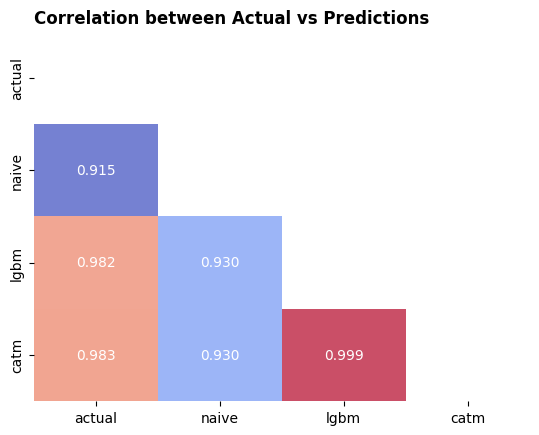

In [70]:
pred_df[['lgbm', 'catm']] = pred_df[['lgbm', 'catm']].map(float)

corr = pred_df.corr(numeric_only=True)

sns.heatmap(corr, mask=np.triu(corr), annot=True, cbar=False, cmap='coolwarm', alpha=0.7, fmt='.3f')
plt.title('Correlation between Actual vs Predictions', fontweight='bold', loc='left');

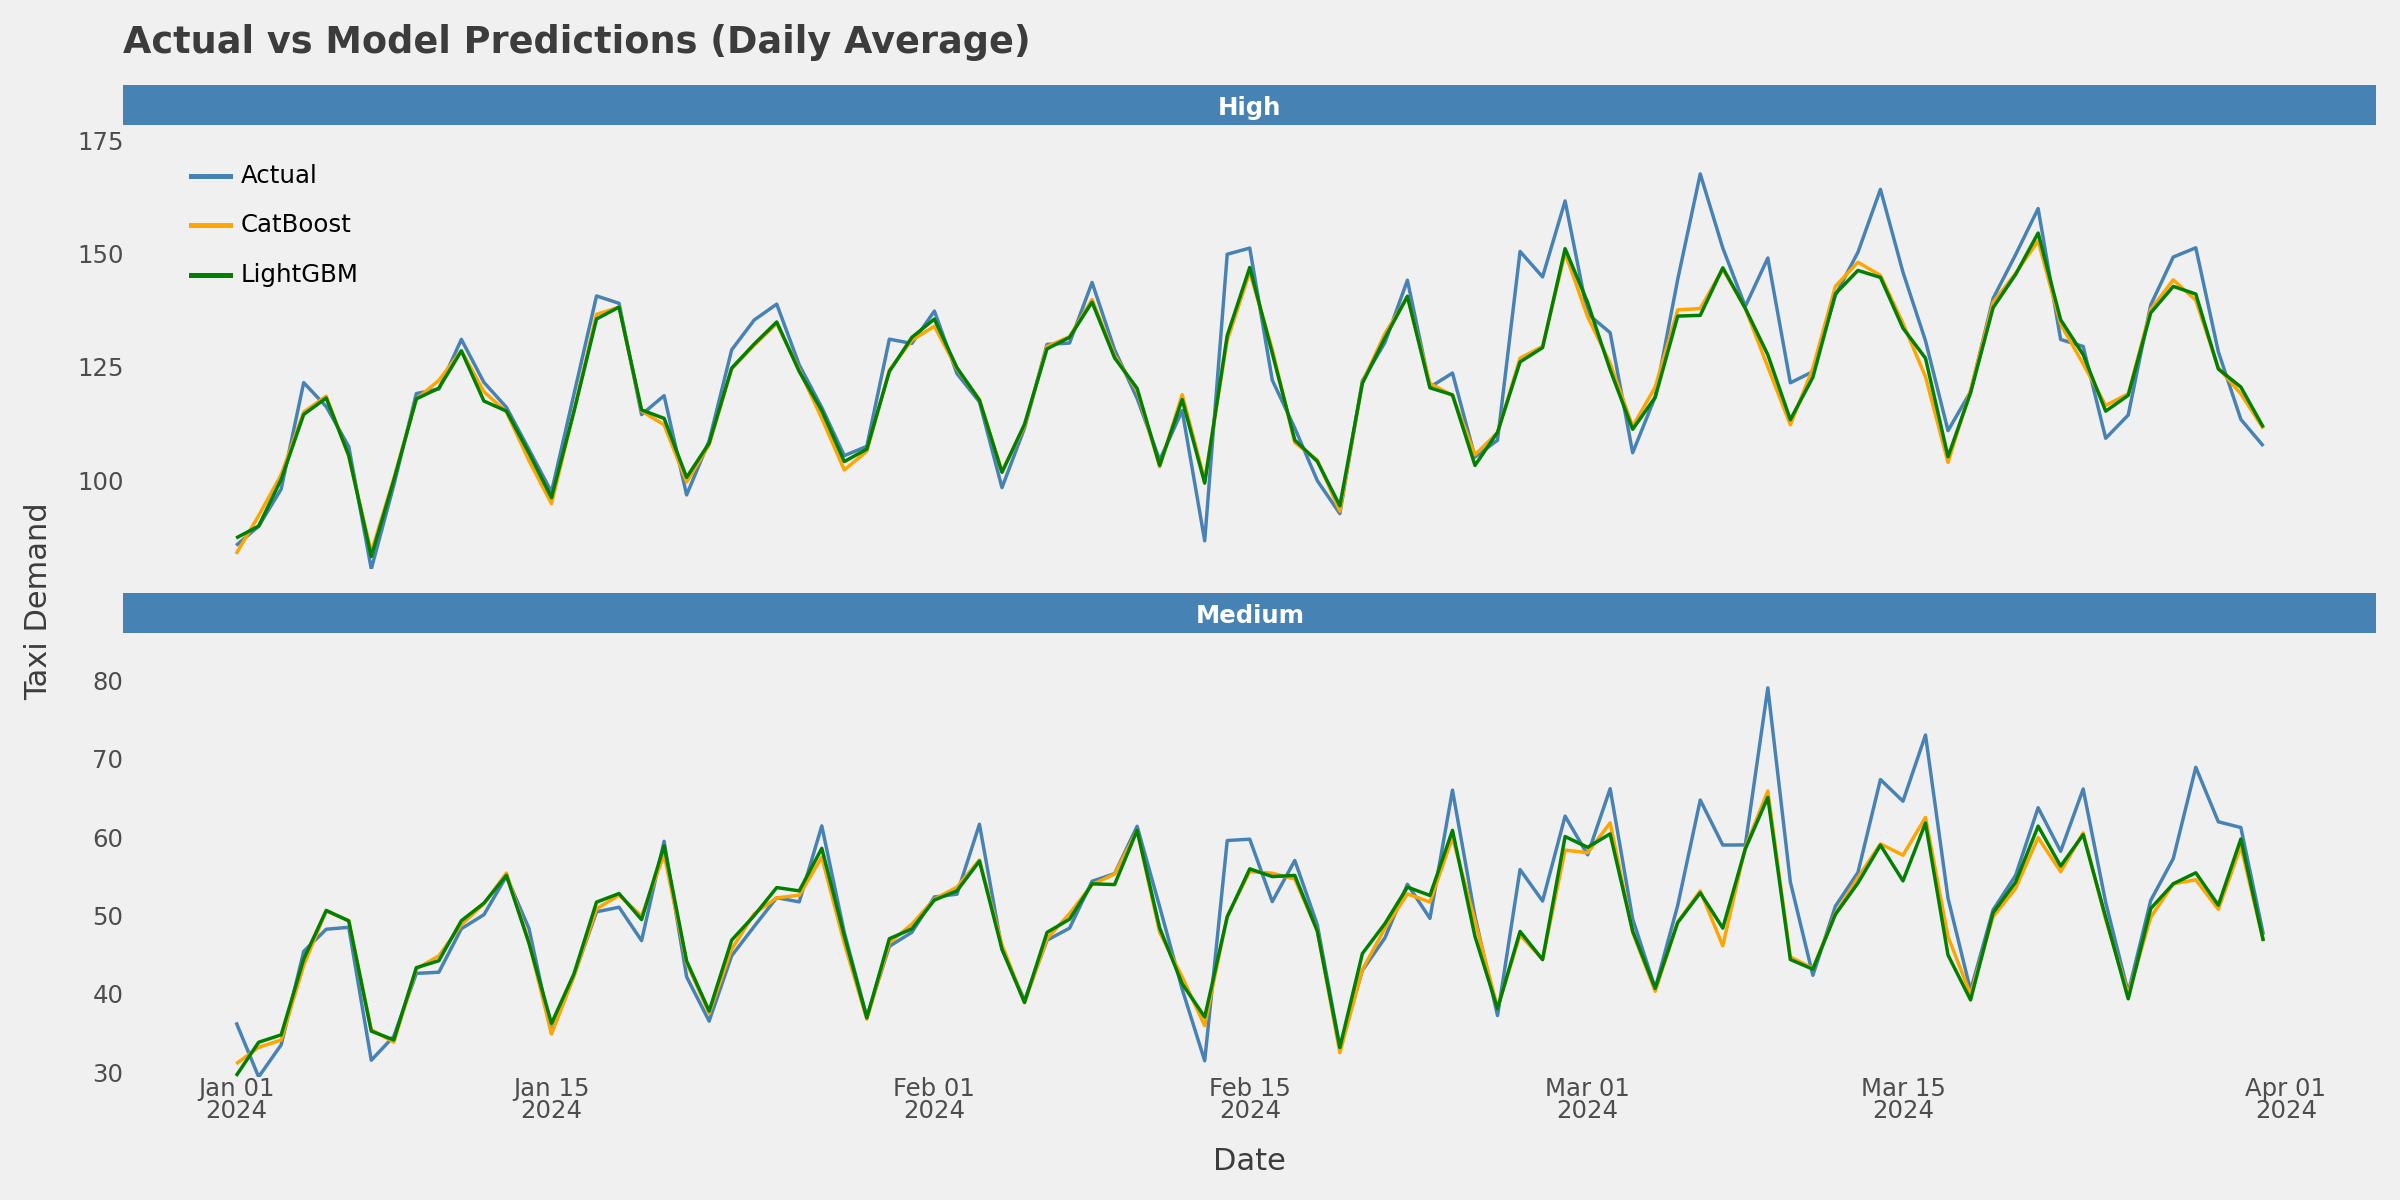

In [71]:
(
    pn.ggplot(
        (pred_df.pivot(columns='demand_group', values=['actual', 'naive', 'lgbm', 'catm'])
                .resample('24h').mean()
                .melt(value_name='values', ignore_index=False)
                .rename(columns={None:'pred_type'})
                .reset_index()
                .query('pred_type != "naive"')
        ), pn.aes(x='ride_datetime', y='np.float64(values)', color='factor(pred_type)')) +
    pn.geom_line(size=0.7) +
    pn.facet_wrap('~demand_group', scales='free_y', nrow=2) +
    pn.theme_538() +
    pn.theme(figure_size=(12,6), 
             legend_key=pn.element_blank(),
             strip_background=pn.element_rect(fill='steelblue'),
             strip_text=pn.element_text(color='white', face='bold'),
             panel_grid=pn.element_blank(),
             plot_title=pn.element_text(hjust=0, face='bold'),
             legend_position_inside=(0.03,1.02),
             legend_position='inside') +
    pn.scale_x_date(date_labels='%b %d\n%Y', date_minor_breaks='1 day') +
    pn.labs(title='Actual vs Model Predictions (Daily Average)', x='Date', y='Taxi Demand', color='') +
    pn.scale_color_manual(values=('steelblue', 'orange', 'green'), labels=('Actual', 'CatBoost', 'LightGBM')) +
    pn.scale_y_continuous(expand=(0, 0, 0.1, 2))
)

Above figure shows the actual average daily demand versus the model predicted demands from Jan 1, 2024 to Mar 31, 2024. 
- Both models seem to better predict the demand for high-demand zones than medium-demand zones
- Both models seem to under-predict taxi demands for March 2024

### April Predictions

In [72]:
# instantiate model class
regressor = Model()

In [73]:
regressor.train(lgbm, pd.concat([xtrain, xval]), pd.concat([ytrain, yval]))

LGBMRegressor(colsample_bytree=0.6, importance_type='gain', learning_rate=0.07,
              max_depth=6, min_child_samples=3, min_child_weight=1,
              n_estimators=2500, n_jobs=-1, num_leaves=20, random_state=234,
              reg_alpha=10, reg_lambda=1, subsample=0.7, verbose=-1)

In [74]:
regressor.train(catm, pd.concat([xtrain, xval]), pd.concat([ytrain, yval]))

In [75]:
test.index = test.index.astype('datetime64[ns]')

In [76]:
test_set = (
    test_demand.assign(demand_group = test_demand.demand_group.map({'high':1, 'medium':0})).reset_index()
    .merge(test.reset_index(), on=['ride_datetime', 'demand_group'], how='right')
    .set_index('ride_datetime')
)

test_set = test_set[train_set.columns]

In [77]:
xtest, ytest = test_set.drop(columns=TARGET), test_set[TARGET]

In [78]:
print(model_metrics(lgbm, xtest, ytest))
print(model_metrics(catm, xtest, ytest))

RMSE: 10.3520	MAE: 7.5352
RMSE: 9.5740	MAE: 6.8133


In [79]:
test_pred_df = pd.DataFrame(index=test_set.index, columns=['demand_group', 'actual', 'lgbm', 'catm'])

test_pred_df['demand_group'] = xtest.demand_group.map({1:'High', 0:'Medium'})
test_pred_df['actual'] = ytest
for i, model in enumerate([lgbm, catm], start=2):
    pred = model.predict(xtest)
    test_pred_df.iloc[:, i] = pred

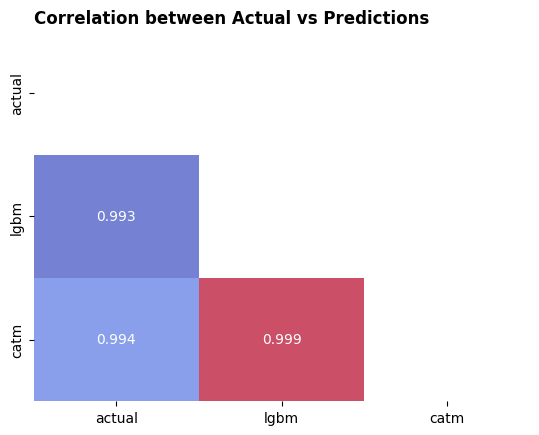

In [80]:
test_pred_df[['lgbm', 'catm']] = test_pred_df[['lgbm', 'catm']].map(float)

corr = test_pred_df.corr(numeric_only=True)

sns.heatmap(corr, mask=np.triu(corr), annot=True, cbar=False, cmap='coolwarm', alpha=0.7, fmt='.3f')
plt.title('Correlation between Actual vs Predictions', fontweight='bold', loc='left');

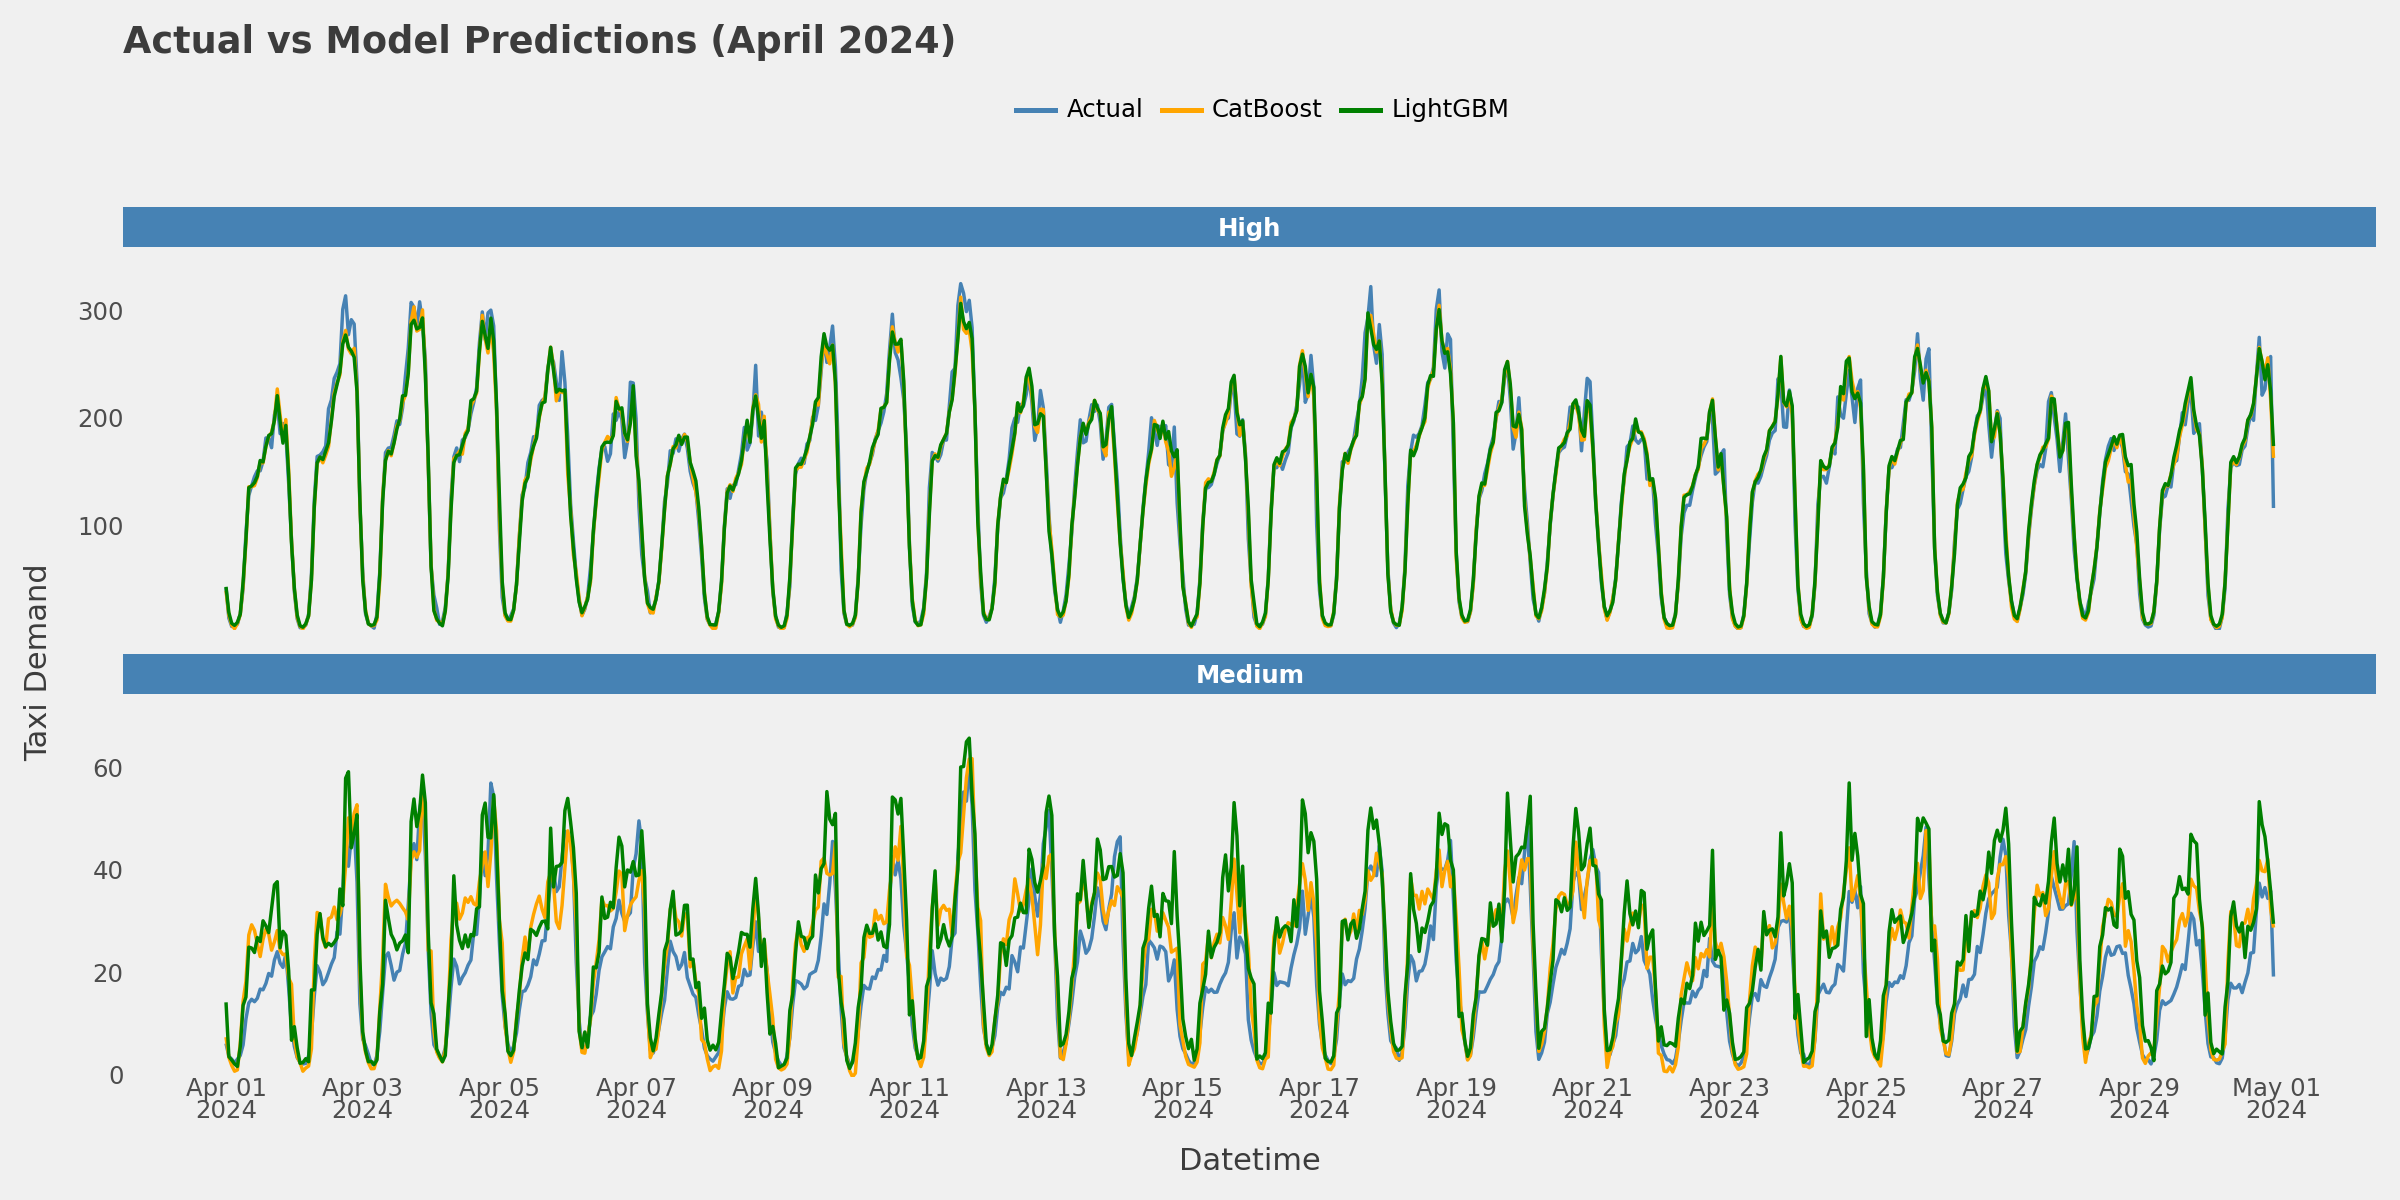

In [81]:
(
    pn.ggplot(
        (test_pred_df.melt(id_vars='demand_group', ignore_index=False, var_name='pred_type', value_name='values')
                .reset_index()
        ), pn.aes(x='ride_datetime', y='np.float64(values)', color='factor(pred_type)')) +
    pn.geom_line(size=0.7) +
    pn.facet_wrap('~demand_group', scales='free_y', nrow=2) +
    pn.theme_538() +
    pn.theme(figure_size=(12,6), 
             legend_key=pn.element_blank(),
             strip_background=pn.element_rect(fill='steelblue'),
             strip_text=pn.element_text(color='white', face='bold'),
             panel_grid=pn.element_blank(),
             plot_title=pn.element_text(hjust=0, face='bold'),
             legend_position='top') +
    pn.scale_x_datetime(date_breaks='2 day', date_labels='%b %d\n%Y', date_minor_breaks='1 hour') +
    pn.labs(title='Actual vs Model Predictions (April 2024)', x='Datetime', y='Taxi Demand', color='') +
    pn.scale_color_manual(values=('steelblue', 'orange', 'green'), labels=('Actual', 'CatBoost', 'LightGBM')) +
    pn.scale_y_continuous(expand=(0, 0, 0.1, 2))
)

- Looking at the predictions for April, both models also seem to better predict taxi demands in high demand areas than in medium demand areas.
- The catboost model seem to better model the demands for medium-demand areas than lightgbm model which seem to under predict and overpredict at some points.
- Looking at the correlation between the actual demand and model predictions, predictions from both models highly correlate with the actual taxi demands.

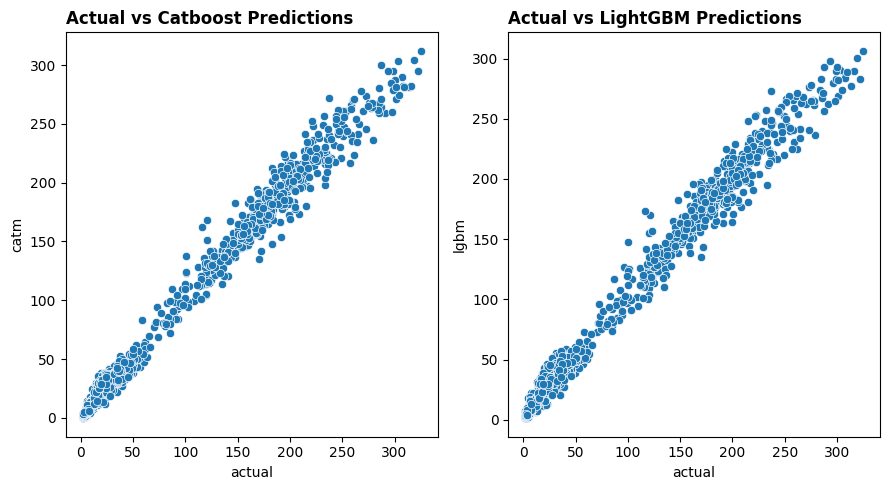

In [85]:
fig, ax = plt.subplots(1,2,figsize=(9,5))
sns.scatterplot(test_pred_df, x='actual', y='catm', ax=ax[0])
ax[0].set_title('Actual vs Catboost Predictions', loc='left', fontweight='bold')

sns.scatterplot(test_pred_df, x='actual', y='lgbm',ax=ax[1])
ax[1].set_title('Actual vs LightGBM Predictions', loc='left', fontweight='bold')

fig.tight_layout()